In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from module.utility import show_images
from common.utility import show_implementation

In [2]:
rose_image = Image.open("images/rose.jpg").resize((288, 216))
rose_image = np.array(rose_image.convert("L"))

# Homography

After the [descriptor chapter](./descriptor.ipynb), we can:
1. identify key points
2. describe the area around the key points
3. perform matching on that points

Now, all that is left is to stitch the two images together based on the key point location.

However, it becomes clear that only shifting the image is not always sufficient to align the two images together.
For example. the image may be rotated, scaled, or even taken from a different plane.

Thus, we need a way to transform the image (based on the transformation of the key points) for better alignment.

## Image projection

In all the previous chapters, we have performed functions on the pixel value of the image.
In a more mathematical form, given a location $x$, the function of the pixel values of the image $F$, and some function $h$, the original image is given as $F(x)$ and our transformed image $G(x)$ is defined as:

$$
G(x) = h(F(x))
$$

However, to align the image, we need to change the domain of $F$.
That is, our transformed image should have the form of:
$$
G(x) = F(h(x))
$$

This means that each pixel at $x$ in $G$ is obtaining its value from the pixel at $h(x)$ in $F$.


### Analogy
A way of thinking about it is to image the image is transformed into individual "blobs of paint".
Then we apply a transformation to move each blob to a new position.
The resulting image would be our desired $G(x)$.

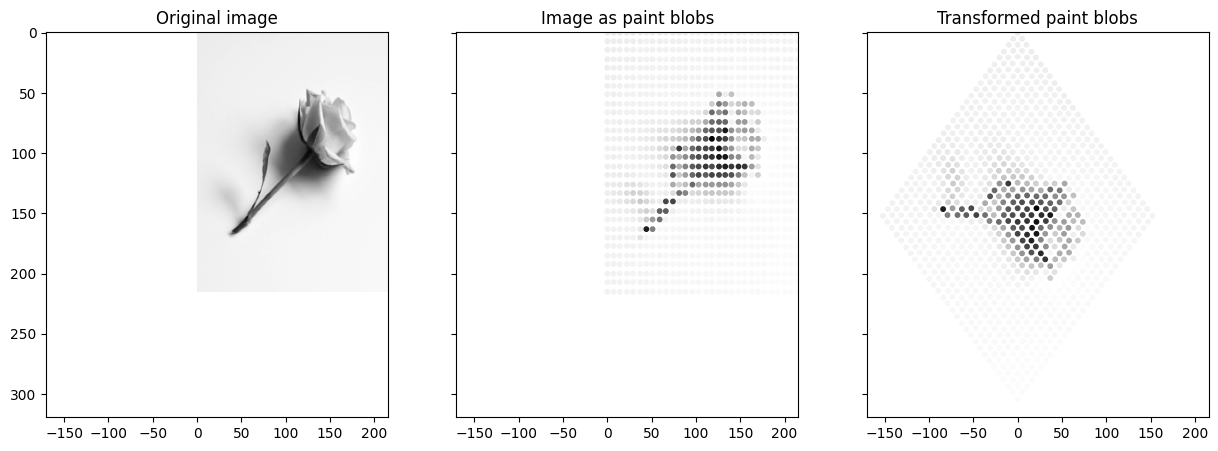

In [3]:
lo = min(rose_image.shape)
square_rose = rose_image[:lo, :lo]
fig = plt.figure(figsize=(15, 5))
axs = fig.subplots(1, 3, sharex=True, sharey=True)
axs[0].imshow(square_rose, cmap="gray")
axs[0].set_aspect("auto")
axs[0].set_title("Original image")

y, x = np.linspace(0, square_rose.shape[0] - 1, num=30, dtype="int32"), np.linspace(
    0, square_rose.shape[1] - 1, num=30, dtype="int32"
)
y, x = np.meshgrid(x, y)
y, x = y.ravel(), x.ravel()
axs[1].scatter(x, y, c=square_rose[y, x], cmap="gray", s=10)
axs[1].set_title("Image as paint blobs")

irt2 = 1 / 2**0.5
transformed = np.array([[irt2, -irt2], [irt2, irt2]]) @ np.vstack((x, y))
axs[2].scatter(*transformed, c=square_rose[y, x], cmap="gray", s=10)
axs[2].set_title("Transformed paint blobs")

axs[0].invert_yaxis()
plt.gca().invert_yaxis()

Notice that parts of our image may land outside of the positive x and y axis.
This is something we need to account for later

## Types of 2D transformations
Since our pixel location is 2 dimensional, we should look at the types of 2D transformation we can perform on an image.

It is as follows:
* Translation
* Rotation
* Scaling
* Affine
* Projective

For image stitching, we would require projective transformation (**homography**) as it will account for the change in plane of the image.

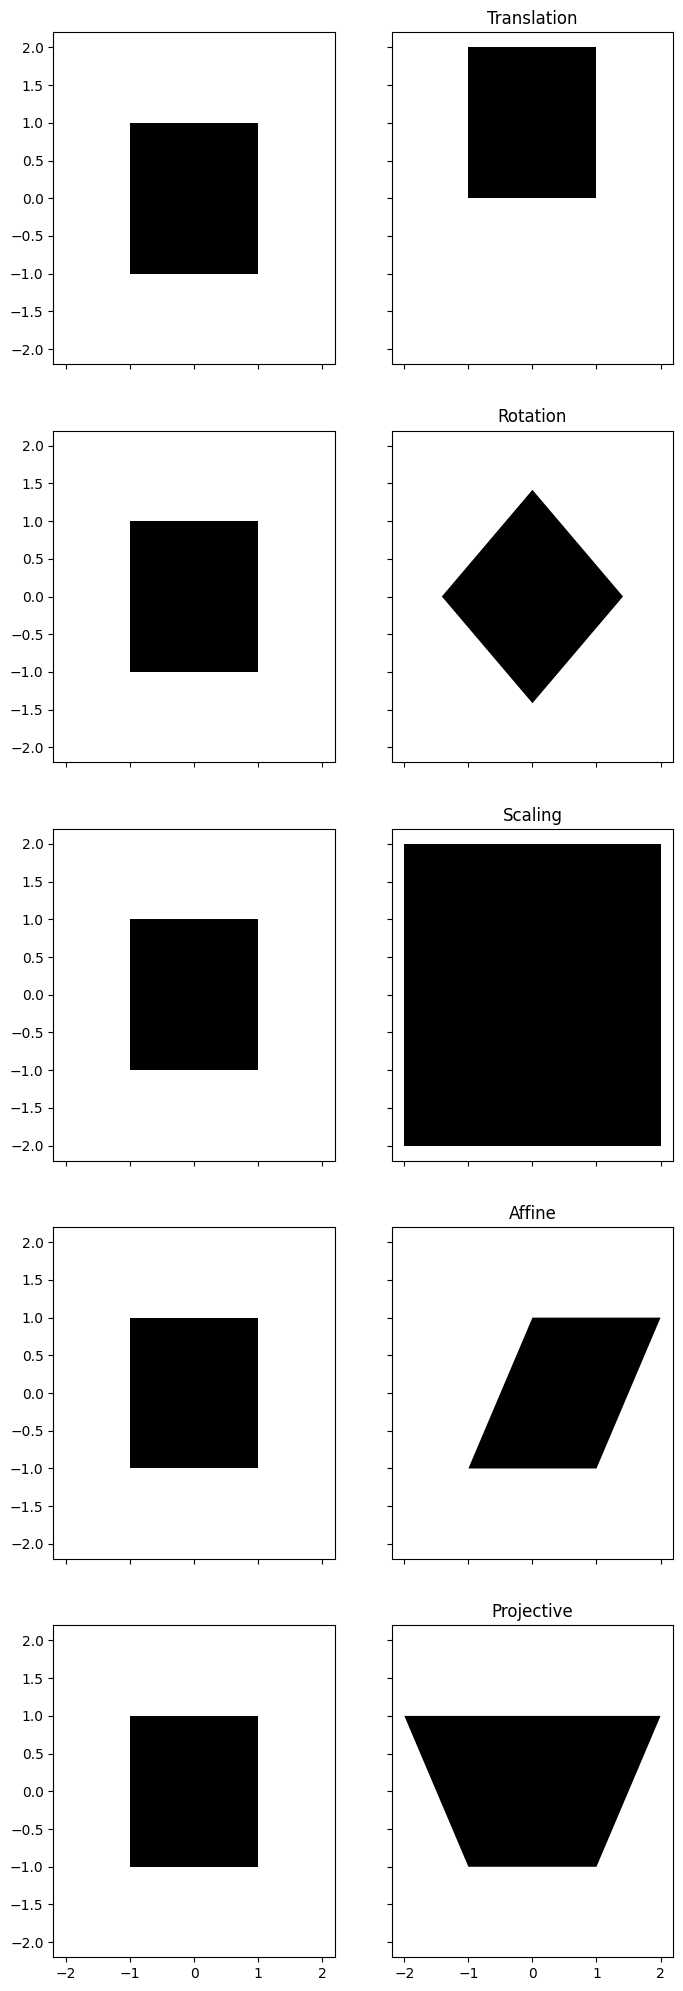

In [4]:
ps = np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]])
rt2 = np.sqrt(2)
all_p_primes = np.array(
    [
        ps + (0, 1),
        [[-rt2, 0], [0, rt2], [rt2, 0], [0, -rt2]],
        ps * 2,
        [[-1, -1], [0, 1], [2, 1], [1, -1]],
        [[-1, -1], [-2, 1], [2, 1], [1, -1]],
    ]
)

titles = ["Translation", "Rotation", "Scaling", "Affine", "Projective"]

num_rows = all_p_primes.shape[0]
fig = plt.figure(figsize=(8, 5 * num_rows))
axs = fig.subplots(num_rows, 2, sharex=True, sharey=True)

for row, p_primes, title in zip(axs, all_p_primes, titles):
    ax1, ax2 = row

    ax1.fill(ps[:, 0], ps[:, 1], "ko")
    ax2.fill(p_primes[:, 0], p_primes[:, 1], "ko")
    ax2.set_title(title)

plt.show()

Hence, we can apply homography when the image have any of the following properties:
* the scene is planar (*ie* a picture of a flat wall)
* or approximately planar (*ie* the scene is far away or have little depth variation)
* the scene is captured under camera rotation **only**, with not translation.

This is together with the (obvious) assumption that the things within the image did not move (significantly) independently of one another.

## Applying homography

Suppose that we wish to transform a pixel location $p$ to $p'$, and we know the homography matrix H.
It is clear that both $p$ and $p'$ are 2 dimensional.
Since homography are linear operations, we can define them as a matrix multiplication with $p$.

Thus, we get $p' = Hp$

<p hidden>TODO: Add linear algebra chapter<p/>

From [linear algebra](./), we learnt that we can use matrices to change the dimension that we are working in, and the matrix $\begin{pmatrix}0 & 1 \\ -1 & 0\end{pmatrix}$ correspond to a 90 degree clockwise rotation on the domain.

In [5]:
# For visualization, we supply this loose image warping function.
# Proper image warping will be discussed later
def loose_warp(p_primes, reference_image):
    p_primes = p_primes.reshape(*reference_image.shape, 2)
    p_primes = p_primes.round().astype("int32")
    if p_primes.ndim == 2:
        return reference_image[p_primes[:, 0], p_primes[:, 1]]
    elif p_primes.ndim == 3:
        return reference_image[p_primes[:, :, 0], p_primes[:, :, 1]]

    raise "Unknown dimension provided"

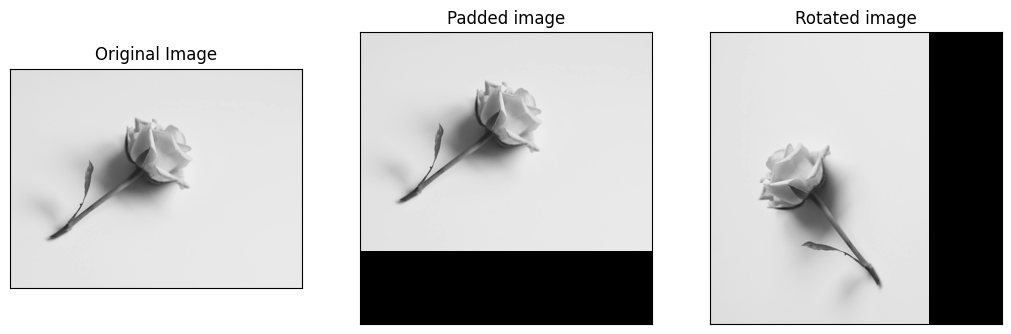

In [6]:
rose_image_padded = np.pad(
    rose_image,
    (
        (0, max(rose_image.shape) - rose_image.shape[0]),
        (0, max(rose_image.shape) - rose_image.shape[1]),
    ),
    constant_values=0,
)

indices = np.indices(rose_image_padded.shape).transpose((1, 2, 0)).reshape((-1, 2))

H = np.array([[0, 1], [-1, 0]])

rotated = np.array([H @ p for p in indices])
h, w = rose_image_padded.shape
transformed_image = loose_warp(rotated.reshape((h, w, 2)), rose_image_padded)
show_images(
    (rose_image, "Original Image"),
    (rose_image_padded, "Padded image"),
    (transformed_image, "Rotated image"),
)

Indeed, the matrix $H$ correspond to a rotation.
We added padding so that the domain of $p$ is the same as $p'$.

<span id='side-note'/>

**NOTE**

($H$ doesn't actually result in the above transformation. 
Suppose we consider the pixel location (10, 0), then after applying the homography, the new pixel location would be (0, -10). 
But since we don't have a pixel value at a negative coordinate, the resulting image would be effectively blank. 
However, `numpy` allows for negative indexing of their array, and it just so happens that the negative index corresponds to a correct domain referencing such that the result is proper rotation.
To achieve a correct homography for rotation, we would need to make the center of the image (0, 0) and perform rotation, which we will account for this we have a better understanding of homography.

Secondly, we are referencing the original image using the transformed pixel as a location.
However, we should be sending all the original image pixels into the transformed domain instead.
Because we did the "wrong" thing, the resultant transformation is actually the inverse operation, _ie_ a 90 degrees **anti-clockwise** rotation.
We are doing the "wrong" process now to show the effects of the matrix operations, the proper method will be discussed under [image warping](#Image-warping))

## Homogeneous coordinates
From using the above formulation of a $2 \times 2$ homography matrix $H$, we can verify that we can indeed perform rotations, scaling, affine and projective transformations.

Through some experimentation, we also would realized that **we are unable to represent translation using a $2\times 2$ matrix $H$**.

A way to reason about it is because we have no way of increasing a certain pixel location by a constant amount as we do not have a "constant row" in $p$ to multiply against when we do the matrix multiplication of $Hp$.

Hence, we introduce the concept of a **homogeneous** coordinates (our previous 2D coordinate are **heterogeneous**)

For any point $p = (x,y)$, we represent it as $P = (x,y,1)$ instead.
And our $H$ is now a $3 \times 3$ matrix.

Hence, we get the following

$$
p = \begin{pmatrix}x \\ y \end{pmatrix} \Rightarrow
P = \begin{pmatrix}x \\ y \\ 1\end{pmatrix} 
$$

$$
P' = HP
$$

$$
P' = \begin{pmatrix}x' \\ y' \\ w' \end{pmatrix} \Rightarrow
p' = \begin{pmatrix}x' / w' \\ y' / w'\end{pmatrix} 
$$

Notice that we can set the last column of $H$ to be $(0, 0, 1)$, and it would correspond to a transformation without translation.

And any of the non-zero values on the last column of H (except the last row) will correspond to a translation transformation.

In [7]:
from module.homography import homography, indices

show_implementation(homography)

def homography(H, ps):
    Ps = np.hstack((ps, np.ones((ps.shape[0], 1))))

    P_primes = np.array([H @ p for p in Ps])
    p_primes = (P_primes[:, 0:2] / P_primes[:,
                2].reshape((-1, 1)))
    p_primes = p_primes.reshape(ps.shape)
    return p_primes


In [8]:
def discretize(p_primes, reference_image):
    p_primes = p_primes.reshape(*reference_image.shape, 2)
    p_primes = p_primes.round().astype("int32")
    valid_xy = p_primes >= 0
    valid_xy &= valid_xy[:, :, ::-1]
    p_primes = np.where(valid_xy, p_primes, 0)
    transformed_image = np.zeros(
        (p_primes[:, :, 0].max() + 1, p_primes[:, :, 1].max() + 1)
    )
    transformed_image[p_primes[:, :, 0], p_primes[:, :, 1]] = reference_image

    return transformed_image

In [9]:
def square(image):
    return np.pad(
        image,
        (
            (0, max(image.shape) - image.shape[0]),
            (0, max(image.shape) - image.shape[1]),
        ),
        constant_values=0,
    )

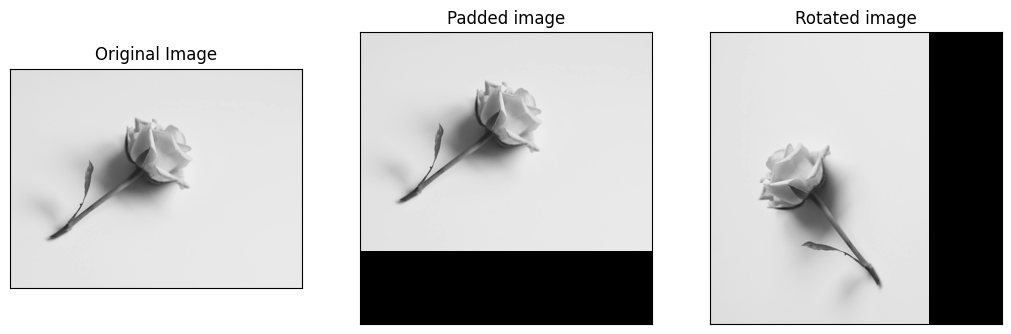

In [10]:
image_padded = square(rose_image)

H = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])
p_primes = homography(H, indices(image_padded))
transformed = loose_warp(p_primes, image_padded)
show_images(
    (rose_image, "Original Image"),
    (image_padded, "Padded image"),
    (transformed, "Rotated image"),
)

$(0, 0, 1)$ on last row gives us the same transformation as in heterogeneous coordinates.

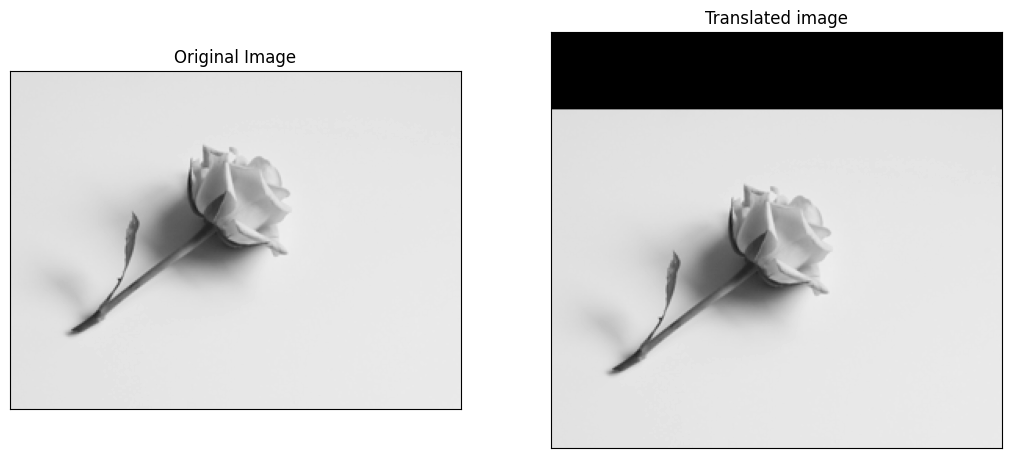

In [11]:
image_padded = square(rose_image)

H = np.array([[1, 0, 50], [0, 1, 0], [0, 0, 1]], dtype="uint32")
p_primes = homography(H, indices(rose_image))
transformed_image = discretize(p_primes, rose_image)
show_images((rose_image, "Original Image"), (transformed_image, "Translated image"))

And the values in the last column dictates the amount of translation to the image.

## Computing homography

Remember our motivation.
We were given a set of points $p$ which are matched to $p'$ in a new image.
Now, we wish to find some homography matrix $H$ such that it matches points $p$ to $p'$, such that we can apply this transformation to all points in the image.

Thus, the problem statement is:

*Given a set of matched key points $(p_i, p_i')$, find the best estimate of $H$ such that*
$$
P' = H P
$$

### Direct Linear Transform

Firstly, we make some assumptions of our desired H.
**We assume that the transformation is "linear"; that is, $w'$ is constant.**
Because of this, we can rewrite our matrix as below, using $\alpha$ as the constant scale factor used to account for $w'$.

$$
\begin{pmatrix}
x' \\
y' \\
1
\end{pmatrix}
=
\alpha
\begin{pmatrix}
h_1 & h_2 & h_3 \\
h_4 & h_5 & h_6 \\
h_7 & h_8 & h_9 \\
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
$$

Comparing the first 2 rows with the last row, we get the following
$$
x'(h_7x + h_8y + h_9) = (h_1x + h_2y + h_3) \\
y'(h_7x + h_8y + h_9) = (h_4x + h_5y + h_6)
$$

Rearranging, we get
$$
h_7xx' + h_8 yx' + h_9x' - h_1 x - h_2 y - h_3 = 0\\
h_7xy' + h_8 yy' + h_9y' - h_4 x - h_5 y - h_6 = 0
$$

Notice that we can describe this as a matrix:
$$
A_ih = 0
$$

where 
$$
 A_i = \begin{pmatrix}-x & -y & -1 & 0  &  0 & 0  & xx' & yx' & x' 
                    \\ 0 &  0 &  0 & -x & -y & -1 & xy' & yy' & y' \end{pmatrix}\\
h = \begin{pmatrix}h_1 & h_2 & h_3 & h_4 & h_5 & h_6 &h_7 &h_8 & h_9\end{pmatrix}^T
$$

Note that there is an $A_i$ for each pair of matched points $p_i, p_i'$, thus we can stack all these constraints together to get
$$
Ah = 0
$$

We can use the perform **singular value decomposition** on $A$ to obtain $$A = U \Sigma V^T$$.
<span hidden>TODO: Add link?</span>

Then we obtain the singular value corresponding to the smallest singular value $h=v_i$.

Lastly, we reshape it to obtain our desired $H$.

In [12]:
from module.dlt import dlt

show_implementation(dlt)

def dlt(ps, p_primes):
    assert len(ps) == len(p_primes)
    xs, ys = ps[:, 0], ps[:, 1]
    x_primes, y_primes = p_primes[:, 0], p_primes[:, 1]

    arr = []
    for x, x_p, y, y_p in zip(xs, x_primes, ys, y_primes):
        arr.append([-x, -y, -1, 0, 0, 0, x * x_p, y * x_p, x_p])
        arr.append([0, 0, 0, -x, -y, -1, x * y_p, y * y_p, y_p])
    A = np.array(arr)
    H = np.linalg.svd(A)[-1][-1].reshape(3, 3)

    return H / H[2][2]  # Make bottom right corner 1 for ease of representation


#### Example

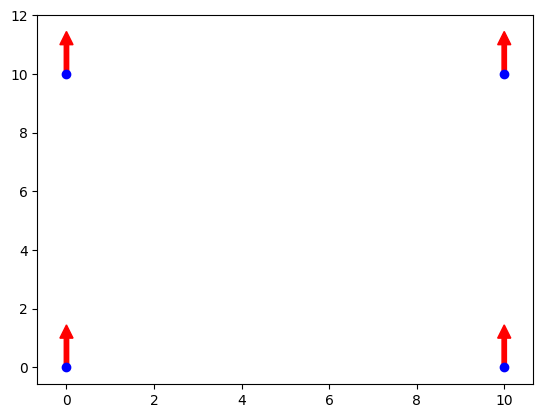

In [13]:
ps = np.array([(0, 0), (10, 0), (0, 10), (10, 10)])
p_primes = np.array([(0, 1), (10, 1), (0, 11), (10, 11)])

plt.plot(ps[:, 0], ps[:, 1], "bo")

for p, p_prime in zip(ps, p_primes):
    x, y = p_prime[0] - p[0], p_prime[1] - p[1]
    plt.arrow(p[0], p[1], x, y, color="red", width=0.1)
plt.show()

Suppose our $p$ and $p'$ were as per above.
We can see that it is a translation of the $y$ variable by 1.

In [14]:
np.set_printoptions(suppress=True)

H = dlt(ps, p_primes)
print(H)

[[ 1.  0.  0.]
 [ 0.  1.  1.]
 [ 0. -0.  1.]]


Thus, this is our computed $H$.
Keen readers would recognize that this is indeed a translation homography of 1 pixel in the $y$ axis.

In [15]:
P_primes = H @ np.vstack((ps.transpose(), np.ones(ps.transpose()[0].shape)))
Ps = P_primes[:2] / P_primes[2]
print(Ps)

[[ 0. 10.  0. 10.]
 [ 1.  1. 11. 11.]]


Applying the homography onto our original $p$ does indeed gives us our $p'$.

Now, moving back to the example of our rose image.

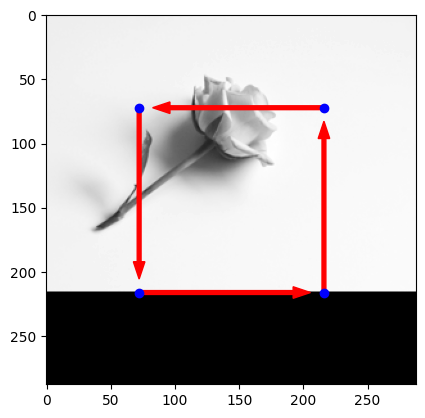

In [16]:
plt.imshow(rose_image_padded, cmap="gray")
ps = [(72, 72), (72, 216), (216, 216), (216, 72)]
p_primes = ps[1:] + ps[:1]
ps, p_primes = np.array(ps), np.array(p_primes)

plt.plot(ps[:, 0], ps[:, 1], "bo")

for p, p_prime in zip(ps, p_primes):
    x, y = p_prime[0] - p[0], p_prime[1] - p[1]
    x, y = np.clip(x, -120, 120), np.clip(y, -120, 120)
    plt.arrow(p[0], p[1], x, y, color="red", width=3)

plt.show()

Suppose we consider the homography derived from the transformation of the above 4 points.
This would be a clockwise rotation of the image around the center.


In [17]:
H = dlt(ps, p_primes)
print(H)

[[ -0.   1.   0.]
 [ -1.  -0. 288.]
 [  0.  -0.   1.]]


Notice the presence of non-zero values on the last column.
This indicates the [translation](#side-note) that we mentioned previously.
Also, our rotational component $\begin{pmatrix} 0 & 1 \\ -1 & 0\end{pmatrix}$ is the same as the previous example too.

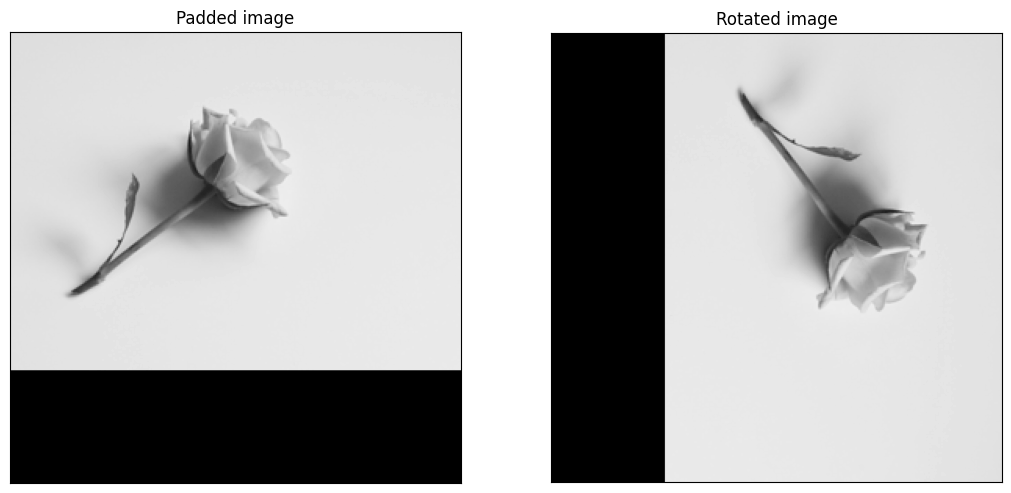

In [18]:
p_primes = homography(H, indices(rose_image_padded))
transformed_image = discretize(p_primes, rose_image_padded)
show_images((image_padded, "Padded image"), (transformed_image, "Rotated image"))

Note that this time, we apply our `discretize` function instead of the `loose_warp`, since none of the `p_primes` would be outside the domain of the original image.

This means that our transformation now does not dependent on the "quirk" of `numpy`, and properly handles the domain.

Also, since we are now properly referencing the image pixels, the same rotational matrix now yields the (correct) clockwise rotation, as compared to the anti-clockwise rotation when we used the `loose_warp`.

#### Drawbacks
* DLT is an linear squares estimation
    * we assumed that transformation is linear, but the underlying transformation may not have been linear.
* Sensitive to scaling in pixel space
    * can be solved by [normalization](#Normalization)
* DLT is greatly affected by outliers
    * can be alleviated with [RANSAC](#RANSAC)

In [19]:
ps = np.array([(0, 0), (10, 0), (0, 10), (10, 10), (5, 5)])
p_primes = np.array([(0, 1), (10, 1), (0, 11), (10, 11), (5, 5)])

Suppose that our $p$ now contains an outlier.
This is the (5, 5) which gets mapped to (5, 5).

In [20]:
H = dlt(ps, p_primes)

P_primes = H @ np.vstack((ps.transpose(), np.ones(ps.transpose()[0].shape)))
Ps = P_primes[:2] / P_primes[2]
print(Ps)

[[ 0.20594425  9.84112385 -0.18617562 10.20481655  4.97006322]
 [ 1.00093698  0.82356825 10.83014202 10.83086697  5.68456075]]


Notice that in our resultant $p'$, every value is affected by the outlier.

#### Normalization
We can normalize $p$ and $p'$ to reduce the effect of scaling in the pixel space.

To normalize points $p_i$'s, we find a transformation $T$, made of translation and scaling, such that the new points $\hat p_i$'s have a centroid at $(0, 0)$, and their average distance from the origin is $\sqrt 2$.

Hence, the complete procedure for DLT is as follows:
1. Normalize $p$ using $T$ to get $\hat p$
2. Normalize $p'$ using $T'$ to get $\hat p'$
3. Apply DLT on the normalized $\hat p$ and $\hat p'$ to get $\hat H$
4. Get $H$ by computing $H= T'^{-1} \hat H T$

---

We notice that outliers can greatly affect the homography computed from DLT, due to DLT trying to solve for the "average" transformation which would be corrupted by an outlier.
If somehow we can ensure that the points we used to compute the homography contains no outlier, then our obtained $H$ would be correct.

Since we have no guarantee that all our matches obtained from [feature matching](./descriptor.ipynb#Feature-matching) are perfect, we need a way to make our homography computation more robust to outliers.

## RANSAC

Let's move away from homography for a moment and discuss a method to obtain a sample without outliers (or with less outliers).

Random sample consensus (RANSAC) uses noisy observations to estimate a model's parameters.
We firstly classify the data as inliers and outliers, then we fits the model to only inliers.

The algorithm is simple:
1. Randomly obtain samples with size required to fit the model
2. Solve for the model parameter using these samples
3. Score the fraction of inliers within a certain threshold of the model
4. Repeat steps 1 to 3 until we find a model with the most inliers.



### Parameters
From the above algorithm, we see that there are a few parameters:
* $\delta$: the distance threshold to consider the point as a inlier
* $N$: the number of iterations to ran RANSAC
* sample size: this would be fixed based on the number of points needed to determine a solution for your model
    * *eg* fitting against a linear model would need a sample size of 2, fitting points against a plane would take sample size of 3, *etc*

We want to choose $\delta$ such that (noisy) inliers still lies within the threshold, usually done empirically through trial and error

If we have a rough estimation on the proportion of inlier vs outliers, we can obtain an upper bound to $N$.


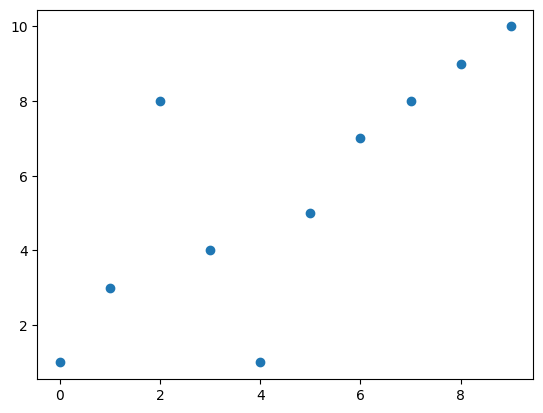

In [21]:
delta = 1
points = np.array(
    [(0, 1), (1, 3), (3, 4), (5, 5), (6, 7), (7, 8), (8, 9), (9, 10), (4, 1), (2, 8)]
)
plt.scatter(points[:, 0], points[:, 1])
plt.show()

Suppose that we are trying to fit a linear model, given the points above.
Notice that 8 points are fitting the majority linear relationship, while 2 points are outliers.
Since the relationship is linear, we know that we need at least 2 points to compute the model.

Suppose that we took points $A$ and $B$ as our sample.

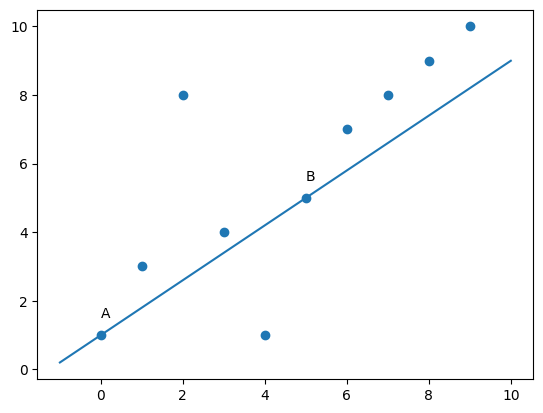

In [22]:
def line(a, b, xs):
    x1, y1 = a
    x2, y2 = b
    m = (y1 - y2) / (x1 - x2)
    c = y1 - m * x1
    return m * xs + c


plt.scatter(points[:, 0], points[:, 1])
sample = points[[0, 3]]

xs = np.linspace(-1, 10)
plt.plot(xs, line(*points[[0, 3]], xs))
plt.text(sample[0][0], sample[0][1] + 0.5, "A")
plt.text(sample[1][0], sample[1][1] + 0.5, "B")
plt.show()

Then the above would be our computed model.
Then, we compare the distance of all the points to their corresponding computed value based on the model.
This is equivalent to finding the distance of the points to the line.

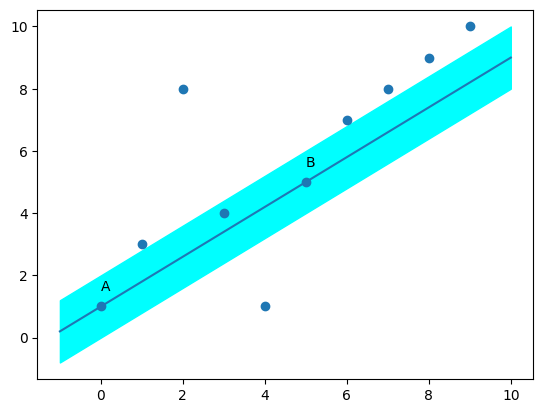

In [23]:
sample = points[[0, 3]]
plt.fill_between(xs, line(*sample, xs) - delta, line(*sample, xs) + delta, color="cyan")
plt.scatter(points[:, 0], points[:, 1])
plt.plot(xs, line(*sample, xs))
plt.text(sample[0][0], sample[0][1] + 0.5, "A")
plt.text(sample[1][0], sample[1][1] + 0.5, "B")
plt.show()

In other words, points that are within the shaded region are **inliers**.
In this case, there are 3 inliers.

Then, RANSAC will repeat the above multiple times and return the best sample it obtained.

In [24]:
from module.ransac import ransac

show_implementation(ransac)

def ransac(sample_pool, N, sample_size, dist_func, delta, return_metric=False):
    best = (None, 0)
    for _ in range(N):
        indices = np.random.choice(
            np.arange(sample_pool.shape[0]), size=sample_size, replace=False)
        sample = sample_pool[indices]
        num_inliers = (dist_func(sample, sample_pool) <= delta).sum()

        if num_inliers > best[1]:
            best = (sample, num_inliers)

    return best if return_metric else best[0]


In [25]:
N = 10
sample_size = 2


def dist(p_sample, points):
    assert p_sample.shape[0] == 2

    p1, p2 = p_sample
    return np.abs(np.cross(p2 - p1, p1 - points) / np.linalg.norm(p2 - p1))


best = ransac(points, N, sample_size, dist, delta, True)

print(
    f"best achieved with points {best[0][0]} and {best[0][1]}, with {best[1]} inliers"
)

best achieved with points [6 7] and [1 3], with 8 inliers


In this case, RANSAC reported that the best fit is with the points (3, 4) and (9, 10), which achieved 8 inliers when fitted.

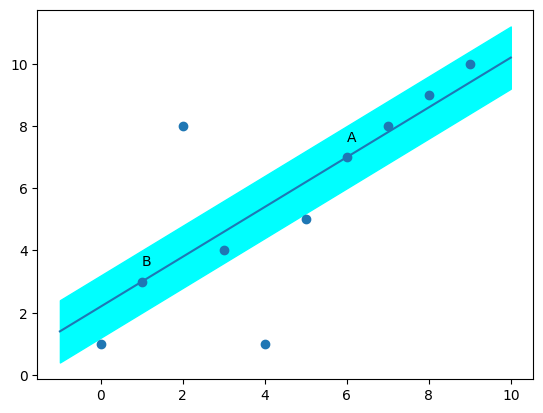

In [26]:
sample = best[0]
plt.fill_between(xs, line(*sample, xs) - delta, line(*sample, xs) + delta, color="cyan")
plt.scatter(points[:, 0], points[:, 1])
plt.plot(xs, line(*sample, xs))
plt.text(sample[0][0], sample[0][1] + 0.5, "A")
plt.text(sample[1][0], sample[1][1] + 0.5, "B")
plt.show()

#### Upper bound of $N$

Each iteration, we are drawing $s$ points to be our sample.
We wish that through $N$ iteration of RANSAC, at least 1 iteration is free of outliers, such that this would surface as the best fit that we obtain.

Suppose that each point has a probability of $e$ of being an outlier.
Then we know that the probability of a sample being free of outlier is simply:
$$
(1-e)^s
$$

Then, the probability of a sample having some outlier is:
$$
1 - (1-e)^s
$$

Following that, the probability of **all** $N$ samples having an outlier is:
$$
(1- (1-e)^s)^N
$$

Therefore, the probability of **some** sample in the $N$ samples having no outlier is:
$$
p = 1 - (1-(1-e)^s)^N
$$

Solving for $N$, we get
$$
\begin{align}
& p = 1- (1- (1-e)^s)^N \\
\Rightarrow & 1 - p = (1- (1-e)^s)^N \\
\Rightarrow & \log(1 - p) = N \log (1- (1-e)^s) \\
\Rightarrow & N = \frac{\log(1-p)}{\log (1- (1-e)^s)} \\
\end{align}
$$

Thus, given some probability $p$ (*eg* 0.99) that we wish our RANSAC to succeed, we can find the required iterations $N$.

In our previous example, we know that 6 out of the 10 points are inliers (the points which fits the line perfectly).
Hence, $e = 6/10 = 0.6$.
And $s=2$ as we require sample size of 2.
Therefore, if we wish to have a 99% chance of having the perfect sample, we would require at least $N = \frac{\log(1-0.99)}{\log(1-(1-0.6)^2} \approx 26.4$ iterations.

(For those curious, if we compute $p$ for our previous experiment when $N=2$, we would get $p=0.825$)

#### Early stopping

Notice that in our algorithm, at some iteration, we may have already obtained a sample with no outlier, but we would still continue looping.
If we have some mechanism of detecting that we obtained an outlier-free sample, then we could end RANSAC earlier.
Suppose that we know the proportion of outliers $e$.
If our model produces an outlier ratio of $e$ when we apply our transformation, then we know that our model is ideal, thus we can terminate our algorithm.

#### Drawback
Notice that to determine $N$ or to apply early stopping, we need to have an estimate on the proportion of outlier $e$, which may not always be feasible.

### Application on homography derivation

Applying RANSAC to our homography derivation, we would get:
1. Given a set of matched point from $p \to p'$.
2. Randomly get a set of at least 4 matched points $p_{sample} \to p_{sample}'$
    * We need at least 4 since we require at least 4 points to determine a homography
3. Compute H using DLT on these points
4. Compute $p_{H}'$ by applying $H$ on $p$
5. Count number of inliers, that is the number of points in $p_H'$ which is within a threshold distance of the corresponding $p_{sample}'$
6. Keep $H$ if it has the largest number of inliers
7. Repeat for a desired number of iterations

Lastly, to further increase robustness, compute $H'$ using all the $p$ belonging to inliers obtained from best $H$.

# Image warping
Now that we are able to obtain a homography $H$, we may realized that we encounter some issues after applying $H$ to our image.
Notice that our homography $H$ can easily result in pixels $p'$ such that they land on non-integer coordinates.
A simple approach would be to discretize the coordinates (possibly by rounding them).
However, there are some issues:
1. Certain destination pixels may not be covered, (*ie* the pixel may land outside of the original image domain, or the pixel may be missing in the original image, in the case of scaling up)
2. Many pixels may map to the same destination, thus we won't know which to fill the destination pixel with

Suppose we have the below transformation.

In [27]:
a = 64
ps = np.array([[72, 72], [72, 216], [216, 216], [216, 72]])
d = np.array([[-a, a], [a, a], [a / 2, -a / 2], [-a / 2, -a / 2]])
p_primes = ps + d

H = dlt(ps, p_primes)

If we apply discretization to warp the image, we would get the below:

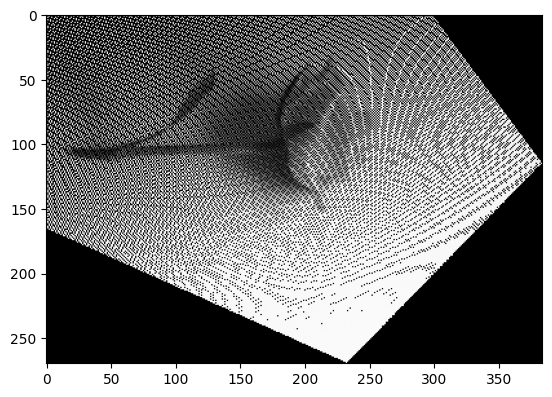

In [28]:
transformed_pixels = homography(H, indices(rose_image))

discrete = discretize(transformed_pixels, rose_image)
plt.imshow(discrete, cmap="gray")
plt.show()

Notice that there are plenty of discretization artifacts, because many pixel location are not filled in the transformed image.

We can apply warping to solve this issue.
Suppose that a source pixel end up in multiple pixel location.
Then we can distribute its intensity among the neighbouring pixels.
Then, for each pixel, we compute its intensity by summing the intensity contributed from all sources.

In [29]:
from module.image_warp import warp

show_implementation(warp)

def warp(pixels, image, n=5, eps=1e-6, max_d=3):
    grid = np.indices(image.shape).transpose(1, 2, 0)

    tree = KDTree(pixels.reshape((-1, 2)))
    dist, indices = tree.query(grid, n, workers=-1, distance_upper_bound=max_d)
    indices[dist == np.inf] = 0

    intensities = image.ravel()[indices]

    metric = (1/(dist+eps) + eps)
    avg_intensities = (intensities * metric).sum(axis=-1) / \
        (metric.sum(axis=-1))
    domain = (dist.min(axis=-1) != np.inf).reshape(image.shape)
    return avg_intensities.round().astype('uint8'), domain


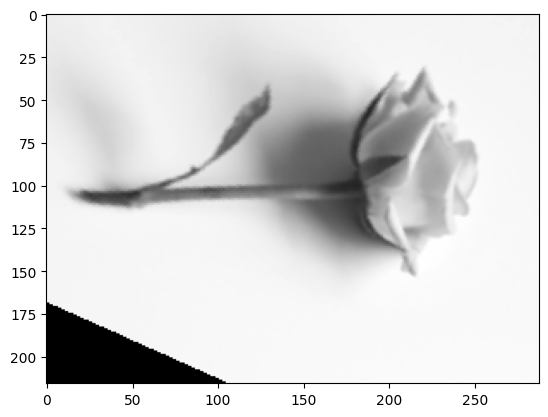

In [30]:
transformed_pixels = homography(H, indices(rose_image))

warped, domain = warp(transformed_pixels, rose_image)
plt.imshow(np.where(domain, warped, 0), cmap="gray")
plt.show()

Hence, the artifacts are no longer present.

# Full homography example

In [31]:
def show_images(*img_label_tuples, grey=True):
    if len(img_label_tuples) == 1 and type(img_label_tuples[0]) == list:
        img_label_tuples = img_label_tuples[0]

    n = len(list(img_label_tuples))
    f = plt.figure(figsize=(10 * n, 5 * n))

    axes = f.subplots(1, n, squeeze=False)[0]

    imgs_max = 1 if all([image.max() <= 1 for image, *_ in img_label_tuples]) else 255

    for ax, (image, label, *others) in zip(axes, img_label_tuples):
        ax.title.set_text(label)
        ax.title.set_fontsize(20)
        autoscale = others[0] if len(others) > 0 else False
        vmin, vmax = (0, imgs_max) if not autoscale else (image.min(), image.max())
        if grey:
            ax.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
        else:
            ax.imshow(image)

        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    f.tight_layout()

In [32]:
stitch0_image = Image.open("images/stitch0.png")
stitch0_image = np.array(stitch0_image.convert("L"))
stitch1_image = Image.open("images/stitch1.png")
stitch1_image = np.array(stitch1_image.convert("L"))

Suppose that we are given the following two images (from a stitching example) to stitch together.

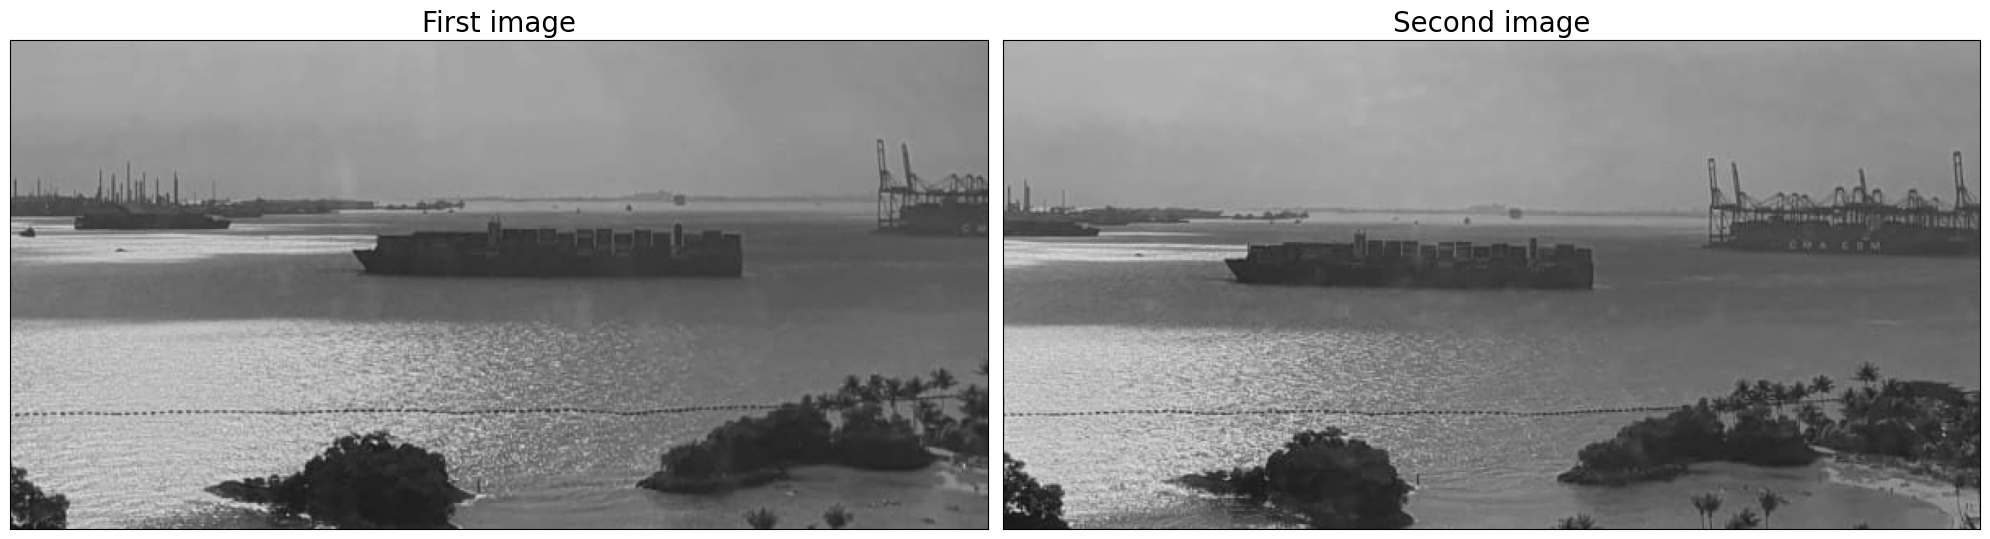

In [33]:
show_images((stitch0_image, "First image"), (stitch1_image, "Second image"))

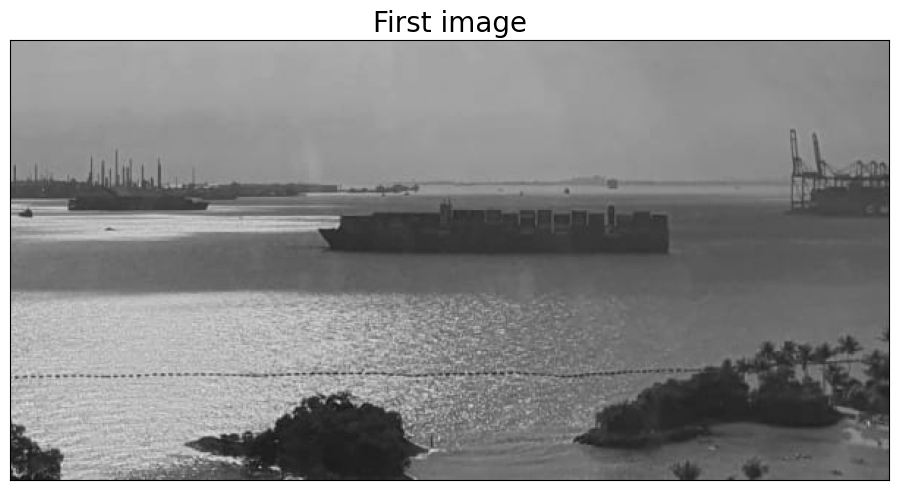

In [34]:
show_images((stitch0_image, "First image"))

Notice that the first image has a full view of the left boat, while the second image has a fuller view of the coast on the right island, as well as the right boat.

Suppose that we have computed the following (handpicked) correspondences.

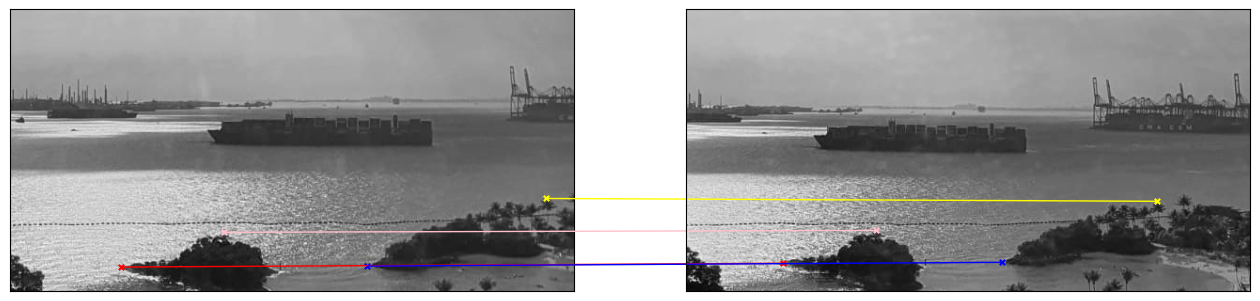

In [35]:
from matplotlib.patches import ConnectionPatch

fig = plt.figure(figsize=(16, 10))
axs = fig.subplots(1, 2, sharex=True, sharey=True)

axs[0].imshow(stitch0_image, cmap="gray")
axs[1].imshow(stitch1_image, cmap="gray")
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].xaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

ps = np.array([(274, 118), (273, 380), (237, 227), (201, 570)])
p_primes = np.array([(270, 102), (269, 336), (235, 201), (204, 500)])

for (py, px), (ppy, ppx), c in zip(ps, p_primes, ["red", "blue", "pink", "yellow"]):
    con = ConnectionPatch(
        xyA=(px, py),
        xyB=(ppx, ppy),
        coordsA="data",
        coordsB="data",
        axesA=axs[0],
        axesB=axs[1],
        color=c,
    )
    axs[1].add_artist(con)

    axs[0].scatter(px, py, s=15, marker="x", c=c)
    axs[1].scatter(ppx, ppy, s=15, marker="x", c=c)

plt.show()

We would obtain the following homography matrix.

In [36]:
H = dlt(ps, p_primes)
print(H)

[[  1.28491043   0.06096153 -38.37581483]
 [  0.15559228   1.13772466 -55.6612885 ]
 [  0.00058982   0.00022751   1.        ]]


And obtain the following image after applying the homography and warping.

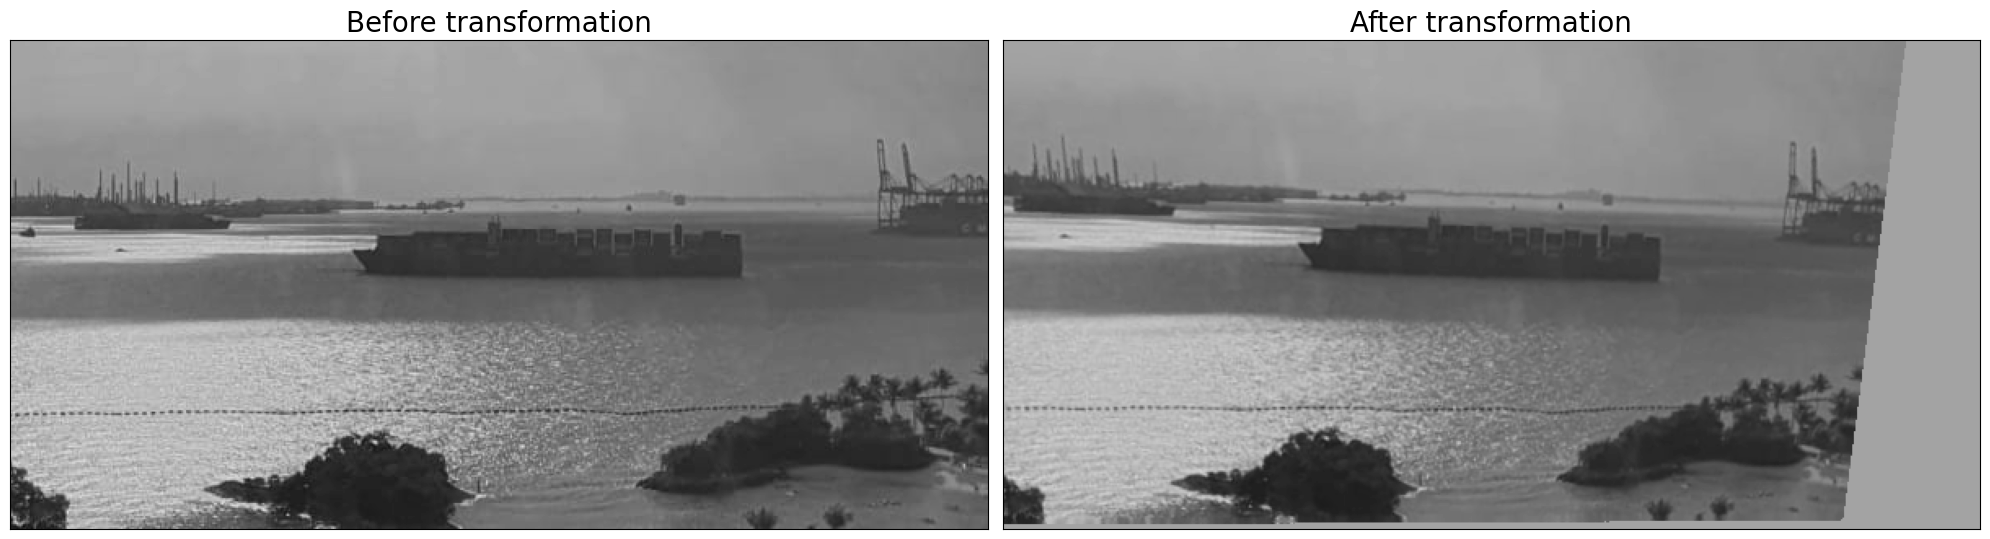

In [37]:
pixels = homography(H, indices(stitch0_image))
warped, domain = warp(pixels, stitch0_image)
masked = np.where(domain, warped, 0)
show_images((stitch0_image, "Before transformation"), (warped, "After transformation"))

Notice that our image "scooted" over to the left, creating a space where we can interlace with our second image.

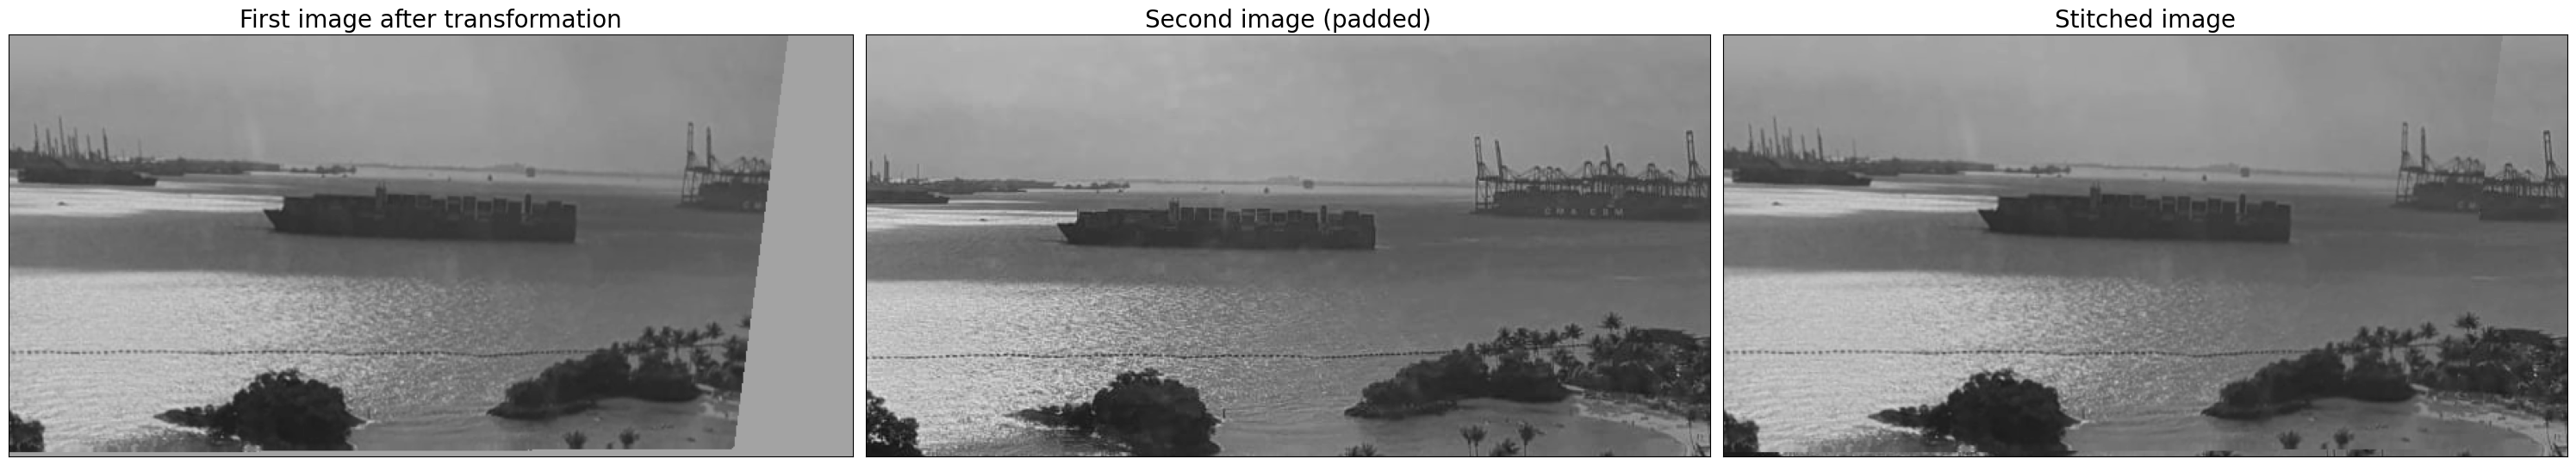

In [38]:
hi_r, hi_c = max(stitch1_image.shape[0], transformed_image.shape[0]), max(
    stitch1_image.shape[1], transformed_image.shape[1]
)

template1 = np.zeros((hi_r, hi_c))
template1[: stitch1_image.shape[0], : stitch1_image.shape[1]] = stitch1_image

template2 = np.zeros((hi_r, hi_c))
template2[: warped.shape[0], : warped.shape[1]] = warped
merged = np.where(domain, template2, template1)

show_images(
    (template2, "First image after transformation"),
    (template1, "Second image (padded)"),
    (merged, "Stitched image"),
)

In the stitched image, we have a full view of the left boat, as well as a better view of the bay on the right.

Upon closer inspection, we could see that the right boat did not stitch as well as the above mentioned objects.
This can be explained by the fact that it is on a different depth as the island, and thus the image of the boat is (likely) have been subjected to a different homography as our reference points.
Or it could also have been that the boat moved significant between the two shots, violating our assumption that the whole image is subjected to the same transformation.